In [1]:
%matplotlib inline
'''This code loads the Fillipazo and Photometry tables and plots data after running a principle component analysis'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PCA_adjustColumns import adjustFili, adjustPhoto
from PCA_merge import merge
from PCA_calc import calc_distance, calc_dm
#from PCA_index import index
from PCA_remName import remName
from sklearn.preprocessing import Imputer, StandardScaler
from PCA_scale import scale
from PCA import perform
from PCA_plot import plot_PCA
from PCA_vectors import vectors
from PCA_color import colorColumns
from PCA_RMSE import RMSE
from sklearn.pipeline import make_pipeline

/Users/Owner/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#load Fili Table
fili = pd.read_csv('Fili15 Table9.csv', delimiter=',')
#load Photometry Table
photo = pd.read_csv('photometry_198.csv', delimiter=',')

#adjust tables 
newfili=adjustFili(fili)
newphoto=adjustPhoto(photo)

#merge tables into one table without duplicate columns
fiPh=merge(newfili, newphoto)

#calculate distance
distance=calc_distance(fiPh)

#return table with distance modulus accounted for  
dm=calc_dm(distance)

newcolumns=newphoto.columns.tolist()
for elem in newcolumns:
    if elem=='shortname':
        continue
    fiPh[elem]=fiPh[elem]-dm

#remove shortname and age columns
newfiPh=remName(fiPh)

In [3]:
#create color columns
BDdict = {'J' : 1.24, 'H' : 1.66, 'K' : 2.19, 'Ks' : 2.16, 'W1' : 3.35, 'W2' : 4.6, 'W3' : 11.56, 'W4' : 22.09, '[3.6]' : 3.51, '[4.5]' : 4.44, '[5.8]' : 5.63, '[8]' : 7.59, 'g' : .48, 'i' : .76, 'r' : .62, 'u' : .35, 'z' : .91 }
newfiPh=colorColumns(newfiPh, BDdict)

In [4]:
#impute TRAIN data
imp=Imputer(strategy="mean")
imp.fit(newfiPh)
data_imputed=imp.transform(newfiPh)
data_imputed=pd.DataFrame(data_imputed,columns=newfiPh.columns.tolist())

In [5]:
from sklearn.cross_validation import train_test_split
train, test=train_test_split(data_imputed, test_size = 0.2)

In [6]:
#scale TRAIN data
scaler=StandardScaler()
scaler.fit(train.loc[:,'H':])
data_scaled=pd.DataFrame(scaler.transform(train.loc[:,'H':]),columns=train.loc[:,'H':].columns.tolist())


In [7]:
#fit PCA (data_scaled, # of components)
pca=perform(data_scaled, .8)

In [8]:
#transform PCA
data_PCA=pd.DataFrame(pca.transform(data_scaled))

In [9]:
loadings=pd.DataFrame(pca.components_,columns=data_scaled.columns.tolist())
loadings_sq=loadings**2
loadings_sq=loadings_sq.transpose()

In [10]:
x=data_PCA[0].reshape(-1, 1)
y=train.Temperature.reshape(-1, 1)

In [11]:
from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#x_=poly.fit_transform(x)
from sklearn.linear_model import LinearRegression
#lr = LinearRegression()
#lr.fit(x_,y)


model=make_pipeline(PolynomialFeatures(2),LinearRegression())
model.fit(x,y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
#scale TEST data
test_scaled=pd.DataFrame(scaler.transform(test.loc[:,'H':]),columns=test.loc[:,'H':].columns.tolist())


In [14]:
#transform PCA
test_PCA=pd.DataFrame(pca.transform(test_scaled))

In [15]:
x2=test_PCA[0].reshape(-1, 1)
y2=test.Temperature.reshape(-1, 1)
#lr.transform(x2)

test_rmse=RMSE(y2, model.predict(x2))

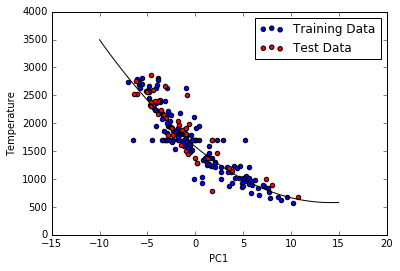

In [16]:
x3=np.linspace(-10,15,100)
xnew=x3[:,np.newaxis]
plt.scatter(data_PCA[0], train.Temperature, label='Training Data')
plt.scatter(test_PCA[0], test.Temperature, c='red', label='Test Data')
plt.plot(xnew, model.predict(xnew), c='black')
plt.xlabel('PC1')
plt.ylabel('Temperature')
plt.legend(loc='best')
#plt.savefig('/Users/Owner/Summer_Research/graphs/KEEP_P1_T.png')
plt.show()

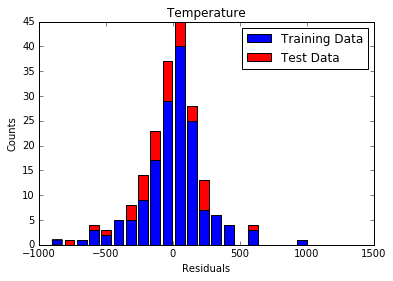

In [17]:
ypred=model.predict(x).reshape(-1,1)
ydata=train.Temperature.reshape(-1,1)
residuals=ypred-ydata        

ypred2=model.predict(x2)
ydata2=test.Temperature.reshape(-1,1)
residuals2=ypred2-ydata2   

n,bins,_ = plt.hist([residuals, residuals2], color = ['blue', 'red'], label=['Training Data','Test Data'], bins=21, stacked=True)

plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.title('Temperature')
plt.legend(loc='best')
#plt.savefig('/Users/Owner/Summer_Research/graphs/KEEP_Res_hist_P1_T.png')
plt.show()

In [18]:
test_rmse

254.02371863254865

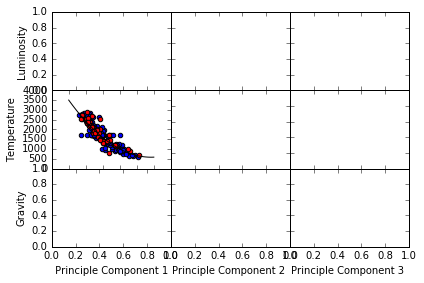

In [88]:
axes = [plt.subplot(3,3,i+1) for i in range(9)]

for ax in range(6):
    axes[ax].set_xticklabels([])
    
for ax in [1,2,4,5,7,8]:
    axes[ax].set_yticklabels([])
    
axes[0].set_ylabel('Luminosity') 
axes[3].set_ylabel('Temperature')
axes[6].set_ylabel('Gravity')
axes[6].set_xlabel(' Principle Component 1 ') 
axes[7].set_xlabel('Principle Component 2 ')
axes[8].set_xlabel('Principle Component 3 ')


axes[3].scatter(data_PCA[0], train.Temperature, label='Training Data')
axes[3].scatter(test_PCA[0], test.Temperature, c='red', label='Test Data')
axes[3].plot(xnew, model.predict(xnew), c='black')

    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)